This project is based on the tutorial Rob Mulla for sentiment analysis with NLTK and tranformers.
I took the data from https://www.kaggle.com/datasets/snap/amazon-fine-food-reviews/

I will perform a basic nltk and then I will use and compare the VADER and ROBERTA models

#Import Libraries

In [101]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random

plt.style.use('ggplot')

import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm .notebook import tqdm

In [102]:
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')
nltk.download('vader_lexicon')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [103]:
!pip install transformers


#Import Data

In [104]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [105]:
url = "drive/My Drive/AmazonFoodReviews/Reviews.csv"
df = pd.read_csv(url)

df.shape

(568454, 10)

df is too large, and because this is a project for educational purposes I will short it to 1000

In [106]:

random.seed(42)
random_indices = random.sample(range(len(df)), 1000)
df = df.iloc[random_indices]
df = df.sort_values(by='Id')
df = df.reset_index(drop=True)

In [107]:
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,426,B000G6RYNE,A1Y3XPZK9ZADFW,albinocrow,0,0,4,1334016000,glad to find them in 1 oz size,"I buy mostly for vending, so the size of the b..."
1,600,B000G6RYNE,A3NXBP212KFH5X,Andrew D. Vorrath,1,1,5,1246406400,Like Spice? Get these,These are the best spicy chips I have ever had...
2,1207,B005O072PC,A11NFERETUWA8Z,"Richard T. Toohey ""Army man 2e""",10,11,1,1263427200,Over Rated (way over priced)Frozen meats,For christmas I ordered some coupons from my d...
3,1774,B001RVFDOO,A9F30PWETQV2M,"Beverly Bernstein ""diet mom""",0,0,5,1261785600,Popchips 6 Flavor Variety,These chips are delicious and each bag only ha...
4,2261,B003NZH3VS,ALXAAUEPCJZH9,Corbett,0,1,1,1327363200,Dispenser too small,I was disappointed when I received this dispen...


In [108]:
df.tail()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
995,565622,B002GKEK7G,A13CIKH3UXEKTP,"Emell ""Emell""",0,2,2,1276387200,"lumpy, boogery consistency",The coffee taste is pretty nice (but it's not ...
996,566212,B004P4POZ8,A3DCEA0DX21JUG,BroMontana,3,6,1,1340668800,"I never write reviews, but this is ridiculous",I ordered two bags of this stuff from amazon a...
997,566391,B004R8L71W,A2D7X9N3IV3S7B,deeper waters,1,1,3,1311724800,Not memorable,"There is something about ""sneaking"" vegetables..."
998,566848,B001PQTYN2,A45RNKZS6TVHI,Momof2,0,0,5,1337472000,Not for mortals,Insanely hot! Just to give you an idea...one d...
999,567297,B003IMSFI6,A2OWQY0IO0KLCQ,Samantha G.,0,0,5,1342137600,Lovely!,This was a birthday gift for my mom. The box w...


In [109]:
df.shape

(1000, 10)

In [110]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Id                      1000 non-null   int64 
 1   ProductId               1000 non-null   object
 2   UserId                  1000 non-null   object
 3   ProfileName             1000 non-null   object
 4   HelpfulnessNumerator    1000 non-null   int64 
 5   HelpfulnessDenominator  1000 non-null   int64 
 6   Score                   1000 non-null   int64 
 7   Time                    1000 non-null   int64 
 8   Summary                 1000 non-null   object
 9   Text                    1000 non-null   object
dtypes: int64(5), object(5)
memory usage: 78.2+ KB


#Exploratory Data Analysis

<Axes: title={'center': 'Reviews'}>

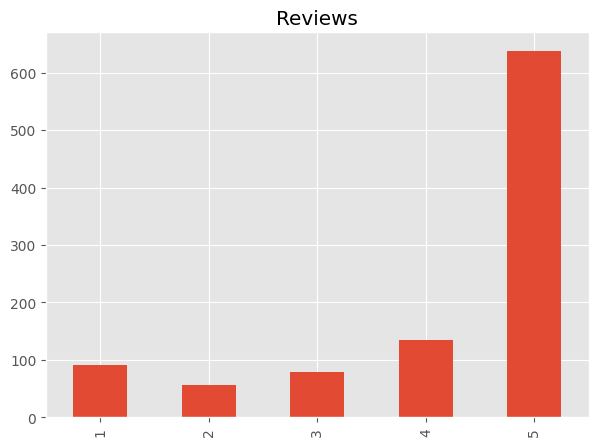

In [111]:
df["Score"].value_counts().sort_index().plot(kind='bar',
                                             title = "Reviews",
                                             figsize=(7,5))

As we can see the 5 star review is the highest value, this may be a problem as the model may be biased towards positive reviews.

#Basic NLTK

NLTK (Natural Language TooliKit) is a package for natural language processing. I use it to tokenize and extract automated information from the text reviews. First let's take a look at a review, this one look like a positive one.

In [126]:
random_review = df['Text'] [120]
print(random_review)

this is my second time ordering from heavenly tea leaves. the service was fast, the presentation with clean, and it was a perfect gift


First I will tokenize it. Tokenization is a preprocessing step that splits text into individual units, such as words or subwords. It helps the model understand and process language efficiently, enables feature extraction, and allows for context and semantics recognition.

In [113]:
token = nltk.word_tokenize(random_review)
token

['These',
 'packages',
 'were',
 'resealable',
 'and',
 'easy',
 'to',
 'use',
 '.',
 'I',
 'heated',
 'the',
 'food',
 'as',
 'well',
 'as',
 'served',
 'it',
 'cold',
 'and',
 'my',
 'grandson',
 'loved',
 'it',
 'either',
 'way',
 '.',
 'It',
 'just',
 'seems',
 'natural',
 'to',
 'warm',
 'peas',
 'a',
 'little',
 'but',
 'he',
 'did',
 "n't",
 'mind',
 'if',
 'I',
 'did',
 "n't",
 '.',
 'The',
 'nutrients',
 'were',
 'excellent',
 'in',
 'this',
 'baby',
 'food',
 'and',
 'I',
 'would',
 'easily',
 'recommend',
 'to',
 'any',
 'new',
 'mother',
 '.',
 'Other',
 'than',
 'making',
 'it',
 'yourself',
 'you',
 'ca',
 "n't",
 'go',
 'wrong',
 'with',
 'this',
 'product',
 '.',
 'I',
 'also',
 'purchased',
 'the',
 '<',
 'a',
 'href=',
 "''",
 'http',
 ':',
 '//www.amazon.com/gp/product/B0051COPFI',
 "''",
 '>',
 'Baby',
 'Gourmet',
 'Organic',
 'Simple',
 'Purees',
 'Stage',
 '1',
 '(',
 '6',
 'Months+',
 ')',
 'Orchard',
 ',',
 'Apple',
 ',',
 'Carrot',
 'and',
 'Prune',
 'Baby',
 '

After this I will extract the POS tags. POS (Part-of-Speech) tags label words with their grammatical roles, like nouns, verbs, adjectives, etc. These tags help the model understand the syntactic structure of a sentence. For example word number 6 'office' is a NN which is a noun.

In [114]:
tagged = nltk.pos_tag(token)
tagged

[('These', 'DT'),
 ('packages', 'NNS'),
 ('were', 'VBD'),
 ('resealable', 'JJ'),
 ('and', 'CC'),
 ('easy', 'JJ'),
 ('to', 'TO'),
 ('use', 'VB'),
 ('.', '.'),
 ('I', 'PRP'),
 ('heated', 'VBD'),
 ('the', 'DT'),
 ('food', 'NN'),
 ('as', 'RB'),
 ('well', 'RB'),
 ('as', 'IN'),
 ('served', 'VBN'),
 ('it', 'PRP'),
 ('cold', 'JJ'),
 ('and', 'CC'),
 ('my', 'PRP$'),
 ('grandson', 'NN'),
 ('loved', 'VBD'),
 ('it', 'PRP'),
 ('either', 'DT'),
 ('way', 'NN'),
 ('.', '.'),
 ('It', 'PRP'),
 ('just', 'RB'),
 ('seems', 'VBZ'),
 ('natural', 'JJ'),
 ('to', 'TO'),
 ('warm', 'VB'),
 ('peas', 'VB'),
 ('a', 'DT'),
 ('little', 'JJ'),
 ('but', 'CC'),
 ('he', 'PRP'),
 ('did', 'VBD'),
 ("n't", 'RB'),
 ('mind', 'VB'),
 ('if', 'IN'),
 ('I', 'PRP'),
 ('did', 'VBD'),
 ("n't", 'RB'),
 ('.', '.'),
 ('The', 'DT'),
 ('nutrients', 'NNS'),
 ('were', 'VBD'),
 ('excellent', 'JJ'),
 ('in', 'IN'),
 ('this', 'DT'),
 ('baby', 'NN'),
 ('food', 'NN'),
 ('and', 'CC'),
 ('I', 'PRP'),
 ('would', 'MD'),
 ('easily', 'RB'),
 ('recommend

 Next I will perform entity recognition. Entity recognition identifies and categorizes named entities (e.g., names of people, places, organizations) in the text. Incorporating named entity recognition into the model enhances its ability to understand and process text by identifying and categorizing specific entities

In [115]:
entities = nltk.chunk.ne_chunk(tagged)
entities.pprint()

(S
  These/DT
  packages/NNS
  were/VBD
  resealable/JJ
  and/CC
  easy/JJ
  to/TO
  use/VB
  ./.
  I/PRP
  heated/VBD
  the/DT
  food/NN
  as/RB
  well/RB
  as/IN
  served/VBN
  it/PRP
  cold/JJ
  and/CC
  my/PRP$
  grandson/NN
  loved/VBD
  it/PRP
  either/DT
  way/NN
  ./.
  It/PRP
  just/RB
  seems/VBZ
  natural/JJ
  to/TO
  warm/VB
  peas/VB
  a/DT
  little/JJ
  but/CC
  he/PRP
  did/VBD
  n't/RB
  mind/VB
  if/IN
  I/PRP
  did/VBD
  n't/RB
  ./.
  The/DT
  nutrients/NNS
  were/VBD
  excellent/JJ
  in/IN
  this/DT
  baby/NN
  food/NN
  and/CC
  I/PRP
  would/MD
  easily/RB
  recommend/VB
  to/TO
  any/DT
  new/JJ
  mother/NN
  ./.
  Other/JJ
  than/IN
  making/VBG
  it/PRP
  yourself/PRP
  you/PRP
  ca/MD
  n't/RB
  go/VB
  wrong/JJ
  with/IN
  this/DT
  product/NN
  ./.
  I/PRP
  also/RB
  purchased/VBD
  the/DT
  </NN
  a/DT
  href=/NN
  ''/''
  http/NN
  :/:
  //www.amazon.com/gp/product/B0051COPFI/NN
  ''/''
  >/CC
  (PERSON Baby/NNP Gourmet/NNP Organic/NNP Simple/NNP Purees/N

#VADER Sentiment scores

For the sentiment score extraction I will use VADER.
VADER( Valence Aware Dictionary for Sentiment Reasoning) is an NLTK module that provides sentiment scores based on the words used. It is a rule-based sentiment analyzer in which the terms are generally labeled as per their semantic orientation as either positive or negative.

Sentiment analysis is used to find out the polarity of the text, which is positive, negative, or neutral. It is one of the advanced research areas in natural language processing. This is widely used in data mining, text mining, etc. It helps collect and analyze opinions about a brand or a product by processing blog posts, comments, reviews, tweets, etc.

In [116]:
SIA = SentimentIntensityAnalyzer()

I will extract the sentiment score of each review. This will give the information of how positive or negative is a review. As you can see in the example, I wrote a psotive review and that gives the score of 0 for negative, 0.2 for neutral and 0.79 for positive. The compound takes a value beetwen -1 for negative and 1 for positive and gave me a total of 0.81.

In [117]:
SIA.polarity_scores("This sweet taste great!")

{'neg': 0.0, 'neu': 0.213, 'pos': 0.787, 'compound': 0.8122}

In [118]:
results={}
for i, row in tqdm(df.iterrows(), total=len(df)):
  text = row['Text']
  myid = row['Id']
  results[myid] = SIA.polarity_scores(text)

  0%|          | 0/1000 [00:00<?, ?it/s]

Now i will create a new df with the df and the sentiment scores combined

In [119]:
vaders = pd.DataFrame(results).T
vaders = vaders.reset_index().rename(columns={'index' : 'Id'})
vaders = vaders.merge(df, how = 'left', on='Id')

In [120]:
vaders.head()

,Id,neg,neu,pos,compound,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,426,0.000,0.806,0.194,0.7717,B000G6RYNE,A1Y3XPZK9ZADFW,albinocrow,0,0,4,1334016000,glad to find them in 1 oz size,"I buy mostly for vending, so the size of the b..."
1,600,0.051,0.693,0.257,0.9842,B000G6RYNE,A3NXBP212KFH5X,Andrew D. Vorrath,1,1,5,1246406400,Like Spice? Get these,These are the best spicy chips I have ever had...
2,1207,0.048,0.853,0.100,0.9302,B005O072PC,A11NFERETUWA8Z,"Richard T. Toohey ""Army man 2e""",10,11,1,1263427200,Over Rated (way over priced)Frozen meats,For christmas I ordered some coupons from my d...
3,1774,0.000,0.710,0.290,0.9331,B001RVFDOO,A9F30PWETQV2M,"Beverly Bernstein ""diet mom""",0,0,5,1261785600,Popchips 6 Flavor Variety,These chips are delicious and each bag only ha...
4,2261,0.043,0.787,0.170,0.8020,B003NZH3VS,ALXAAUEPCJZH9,Corbett,0,1,1,1327363200,Dispenser too small,I was disappointed when I received this dispen...


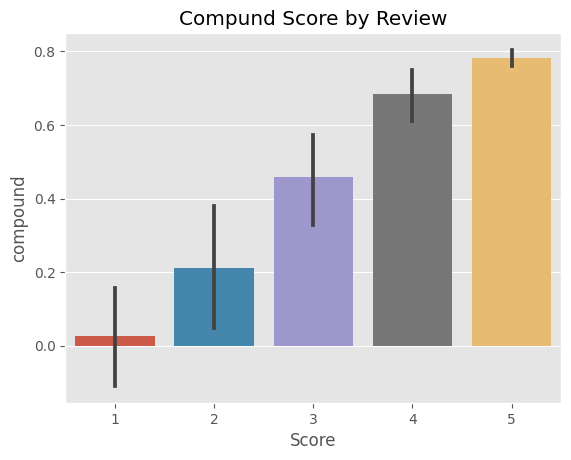

In [124]:
ax = sns.barplot(data=vaders, x='Score', y='compound')
ax.set_title('Compund Score by Review')
plt.show()

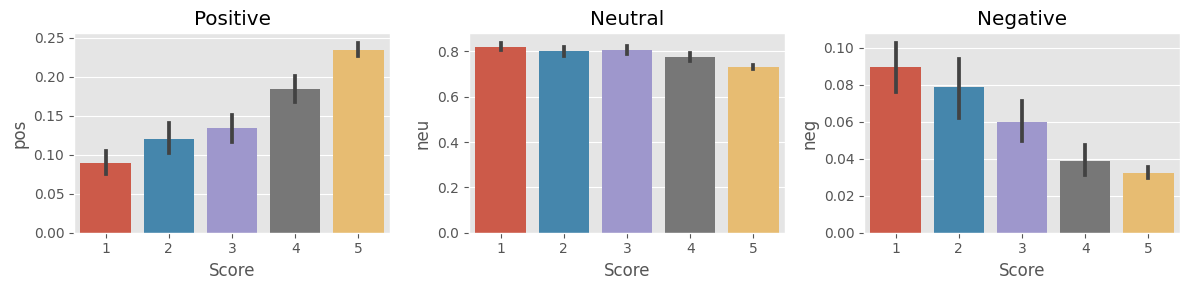

In [125]:
fig, axs = plt.subplots(1, 3, figsize=(12, 3))
sns.barplot(data=vaders, x='Score', y='pos', ax=axs[0])
sns.barplot(data=vaders, x='Score', y='neu', ax=axs[1])
sns.barplot(data=vaders, x='Score', y='neg', ax=axs[2])
axs[0].set_title('Positive')
axs[1].set_title('Neutral')
axs[2].set_title('Negative')
plt.tight_layout()
plt.show()

As we can see in the first plot the compound score is higherand follows the stars review system, the same goes for the positiveand the negative scores. The neutral seems to stay constant with a short variation.

That means that the VADER works well.

Next I will use the ROBERTA pretrained model. The VADER model evaluate every single word by it self, that means that it does not gives attention to the context. ROBERTA is a transformer based model that can give attention to the context and can understand if a phrase is sarcasm.

#Roberta pretrained Model

RoBERTa (A Robustly Optimized BERT Pretraining Approach) is a variant of the BERT (Bidirectional Encoder Representations from Transformers) model. It's a pre-trained language model developed by Facebook AI that excels in understanding context and semantics in natural language processing tasks. RoBERTa employs large-scale training data, extensive pretraining, and advanced techniques for robust optimization, resulting in state-of-the-art performance on various NLP tasks, including text classification, language understanding, and text generation.

In [121]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

In [122]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

Let's take a look an the previous random_review using VADER

In [130]:
print(random_review)
SIA.polarity_scores(random_review)

this is my second time ordering from heavenly tea leaves. the service was fast, the presentation with clean, and it was a perfect gift


{'neg': 0.0, 'neu': 0.588, 'pos': 0.412, 'compound': 0.9231}

Now lets take a look at the ROBERTA model for the same review.

To do this first I will encode the review to feed it to the model. I will run the model on it, and the transform the tensor output to a numpy and apply softmax on it because that is a multi-class classification.

In [131]:
encoded_review = tokenizer(random_review, return_tensors='pt')
output = model(**encoded_review)
scores = output[0][0].detach().numpy()
scores = softmax(scores)
scores_dict = {
    'roberta_neg' : scores[0],
    'roberta_neu' : scores[1],
    'roberta_pos' : scores[2]
}
print(scores_dict)

{'roberta_neg': 0.0012925523, 'roberta_neu': 0.014188047, 'roberta_pos': 0.98451936}


As we can see ROBERTA is more confident that this is a positive review

In [136]:
def polarity_scores_roberta(random_review):
    encoded_review = tokenizer(random_review, return_tensors='pt')
    output = model(**encoded_review)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    scores_dict = {
        'roberta_neg' : scores[0],
        'roberta_neu' : scores[1],
        'roberta_pos' : scores[2]
    }
    return scores_dict

Now I will run the model on every review and then create a df with both the ROBERTA and VADER results

I also put the try and except because based on the tutorial I the dataset I use there are reviews that their lenght is too big for the model to compute.

In [137]:
results = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    try:
        text = row['Text']
        myid = row['Id']
        vader_result = SIA.polarity_scores(text)
        vader_result_rename = {}
        for key, value in vader_result.items():
            vader_result_rename[f"vader_{key}"] = value
        roberta_result = polarity_scores_roberta(text)
        both = {**vader_result_rename, **roberta_result}
        results[myid] = both
    except RuntimeError:
        print(f'Broke for id {myid}')

  0%|          | 0/1000 [00:00<?, ?it/s]

Broke for id 30095
Broke for id 76067
Broke for id 89815
Broke for id 146414
Broke for id 255837
Broke for id 343255
Broke for id 356386
Broke for id 372529
Broke for id 376396
Broke for id 393538
Broke for id 420173
Broke for id 424046
Broke for id 463188


In [139]:
results_df = pd.DataFrame(results).T
results_df = results_df.reset_index().rename(columns={'index': 'Id'})
results_df = results_df.merge(df, how='left')

#Compare the models

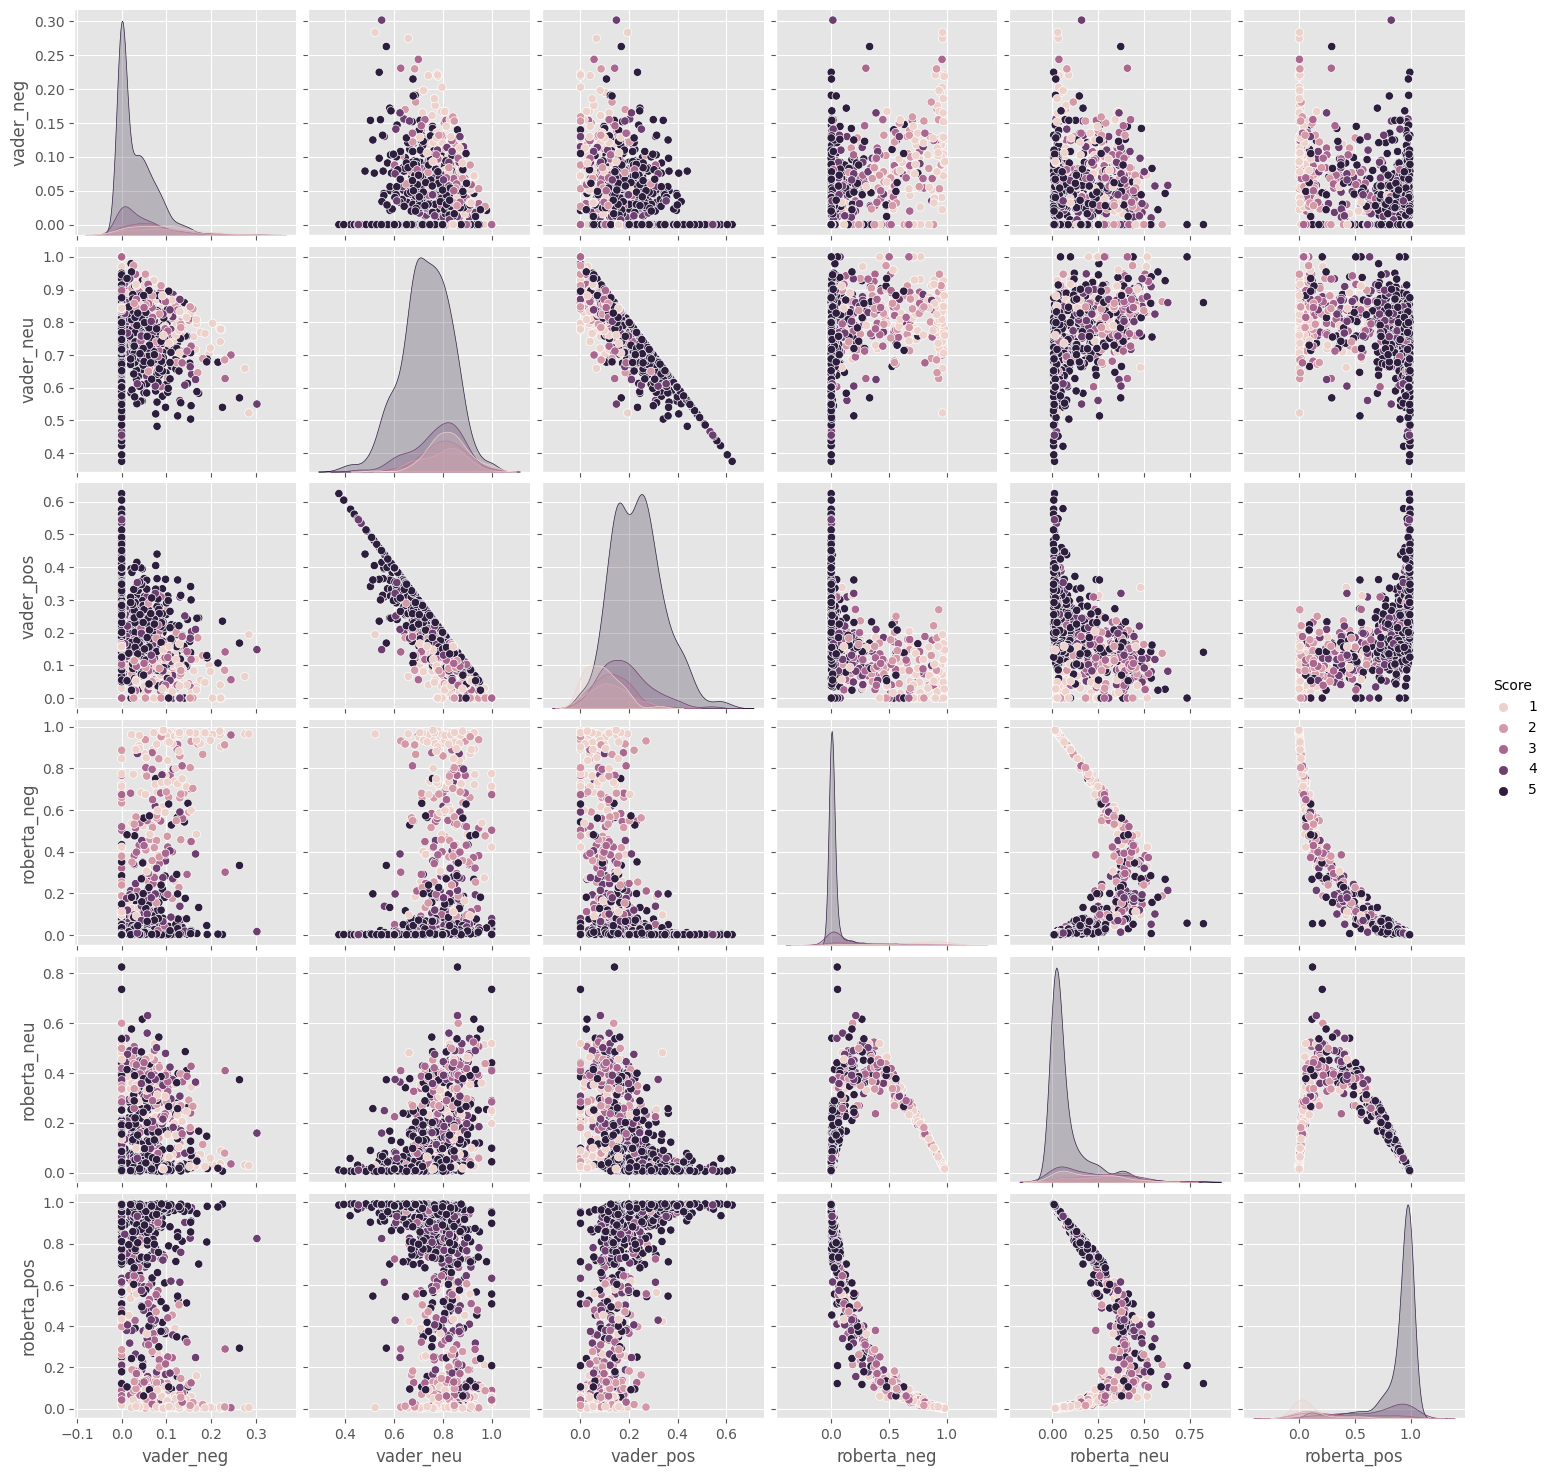

In [140]:
sns.pairplot(data=results_df,
             vars=['vader_neg', 'vader_neu', 'vader_pos',
                  'roberta_neg', 'roberta_neu', 'roberta_pos'],
            hue='Score')
plt.show()

We can see that the ROBERTA has short destribution, and is more confident to classify the reviews. Also the VADER is more to the right side on the positive reviews that means that is not so sure about the positive reviews compared to ROBERTA. Both works good on the negative side but overall ROBERTA wins.